
**7th International Conference on Debris-Flow Hazards Mitigation**   
## Deciphering debris-flow seismograms at Illgraben, Switzerland    
**Michaela Wenner, Fabian Walter, Brian McArdell, Daniel Farinotti**

ETH Zurich



### Abstract

Mass wasting, such as rockfalls, landslides and debris flows in steep mountain terrain, has a high destructive potential, and plays a key role in both erosion and landscape evolution. As an alternative to many conventional approaches, seismology allows monitoring of such mass movements at safe distances, provides estimates of event location and timing, and can give insights into dynamics and rheology granular flows. Here, we analyze seismic data recorded during the 2017 and 2018 debris-flow seasons at Illgraben, a steep canyon located in Switzerland. Yearly precipitation is controlled by summer rainstorms with high rainfall intensity during which mass wasting including rock-slope failure and debris flows occur regularly. The frequent debris-flow occurrence (on average three events per year) makes the Illgraben an ideal site for cross-validating a seismically-derived event catalog of mass movements with “ground-truth data”, such as digital terrain models, flow depths estimates and other in-torrent measurements. We present seismic frequency characteristics of the Illgraben debris-flow series and investigate how the seismic signature depends on actual debris-flow characteristics, such as grain sizes, and on propagation effects of the generated seismic waves. Whereas these two effects are usually difficult to separate, the source component contains valuable information on the flow’s material composition. Stations that are close to the torrent, we find that dominant frequencies in the recorded signal reflect the distance to the dominant source. For one particular station, this is shown on recordings of several events, where a dominant frequency of about 5.5 Hz indicates the passing of the flow at a 48m check dam. Power spectral densities at that instance give an estimate of the particle content of the debris flow. We also find that a jump in dominant frequency does not necessarily reflect the location of the flow front. Seismic studies of debris-flow dynamics and material composition should therefore not be limited to entire debris-flow seismograms, but instead focus on individual time windows and consider different sensors separately. The presented analysis underlines the use of seismic data in torrent and landscape studies.

![bla](material/Illgraben_all-01.png)

Fig. 1. (a) Overview of the Illgraben catchment and the instrumentation installed during the debris-flow season (June-August) 2018. Seismometer locations (white triangles), the area of sediment supply for the debris flows (shaded red area), and the position of the 48 m tall check dam 1, and check dam 29 (black squares) are depicted (b) 3D orthophoto with sediment deposition area in red and check dam 1 shown on a photo. (c) Channel-receiver distances for all seismic stations installed in 2018. The y-axis represents the distance whereas the x-axis marks the position along the channel (origin at the head of the catchment; 5000m corresponds to the Illbach inflow into the Rhône river). Dashed (continuous) lines show the section where the flow is approaching (moving away from) the station.

In [1]:
%matplotlib notebook
import obspy
from obspy import UTCDateTime
from obspy import signal
from obspy.signal import filter

import numpy as np

import seaborn as sns

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.dates import DateFormatter
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm 
from collections import Counter
import matplotlib.gridspec as gridspec
from matplotlib import ticker

import scipy
from scipy import signal
from scipy.signal import argrelextrema
from scipy.fftpack import hilbert
from scipy.signal import (cheb2ord, cheby2, convolve, get_window, iirfilter,
                          remez)
from scipy.signal import sosfilt
from scipy.signal import zpk2sos
from scipy.signal import savgol_filter

from scipy.optimize import curve_fit

import datetime
from datetime import date

plt.style.use('seaborn-white')

In [2]:
def rere(st, inv):
    """ 
    Remove instrument response from seismic data
    :param st: Stream of all recorded events
    :type st: obspy.core.stream.Stream
    :param inv: station information (inventory)
    :type inv: obspy.core.inventory.inventory.Inventory
    
    """
    # Preprocessing
    pre_filt = [0.005, 0.006, 45.0, 50.0]
    st.detrend('linear')
    st.detrend('demean')
    # Remove response
    st.remove_response(inventory = inv, pre_filt = pre_filt, \
            output = 'VEL', water_level = 60, plot=False)
    return st


## Recorded debris flows in 2017 and 2018

In [3]:
# Read file with available infos of debris flows
infos = pd.read_csv('./material/debris_flows.csv')
infos

,date,timeCD1,timeILL11,timeILL12,timeILL13,timeILL16,timeILL17,timeILL18,velocity,depth,volume,precipitation,infos
0,2017-05-29,16:58:00,dd:dd:dd,17:02:07,17:07:27,dd:dd:dd,dd:dd:dd,16:58:55,6.67,6.18,100000,11.2,-
1,2017-06-03,23:27:38,dd:dd:dd,23:33:09,23:35:38,23:14:21,23:17:37,23:25:04,5.10,4.10,90000,6.6,two surges
2,2017-06-14,19:30:48,dd:dd:dd,19:33:40,19:39:43,19:24:59,19:23:28,19:31:12,7.20,4.30,,32.8,fast
3,2018-06-11,10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN
4,2018-06-12,18:26:06,19:04:40,18:38:40,18:57:20,dd:dd:dd,18:24:00,18:30:00,NaN,NaN,NaN,13.6,small
5,2018-07-25,16:50:27,17:10:39,17:00:10,17:04:44,16:46:33,16:48:01,16:56:20,NaN,NaN,NaN,15.2,very slow
6,2018-08-08,17:45:08,18:01:37,17:52:30,17:56:30,17:42:50,17:42:41,17:47:28,NaN,NaN,NaN,4.0,-


In [4]:
dates_flows = {1:'2017-05-29', 2:'2017-06-03', 3:'2017-06-14', 4:'2018-06-11', \
               5:'2018-06-12', 6:'2018-07-25', 7:'2018-08-08'}
# Choose event
ev_date = dates_flows[7]

# Get event infos from file
event = infos.loc[infos['date'] == ev_date]

# Read event times from file
t_CD01 = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeCD1']))

## Plot seismic data, spectrogram and waveform and spectra of a zoom in on ILL12

In [5]:
# Read data
if t_CD01.year == 2017:
    st = obspy.read('./material/*%3d*' %t_CD01.julday)
    inv = obspy.read_inventory('./material/ILL1-8_inventory.xml')
elif t_CD01.year == 2018:
    st = obspy.read('./material/*%3d*' %t_CD01.julday)
    inv = obspy.read_inventory('./material/ILL11-18_inventory.xml')

st.trim(t_CD01 - 0.5*7200, t_CD01 + 0.5*7200)
st.merge(method=1, fill_value='interpolate')
#st.decimate(2)
st = rere(st, inv)
st.filter('bandpass', freqmin=1, freqmax=45)

8 Trace(s) in Stream:
XP.ILL11..HHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL12..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL13..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL14..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL15..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL16..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL17..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL18..EHZ | 2018-08-08T16:45:08.000001Z - 2018-08-08T18:45:08.000001Z | 100.0 Hz, 720001 samples

In [10]:
# Cut data according to time when flow is passing the station 
# Assuming the amplidute at station is highest at station passage
env = obspy.signal.filter.envelope(st.select(station="ILL12")[0].data)

dt_m = 400
dt_p = 400
times = st[0].times()
t_ref = st[0].stats.starttime + times[np.argmax(env)]
tr2 = st.select(station="ILL12")[0].copy()
tr2.trim(t_ref - dt_m, t_ref + dt_p)

st_ev = st.copy()
st_ev.trim(t_ref - 15*60, t_ref + 45*60)
st_ev = rere(st_ev,inv)
st_ev.detrend('demean')
st_ev.filter('bandpass', freqmin=3, freqmax = 45)

8 Trace(s) in Stream:
XP.ILL11..HHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL12..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL13..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL14..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL15..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL16..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL17..EHZ | 2018-08-08T17:37:45.520000Z - 2018-08-08T18:37:45.520000Z | 100.0 Hz, 360001 samples
XP.ILL18..EHZ | 2018-08-08T17:37:45.520001Z - 2018-08-08T18:37:45.520001Z | 100.0 Hz, 360001 samples

<IPython.core.display.Javascript object>


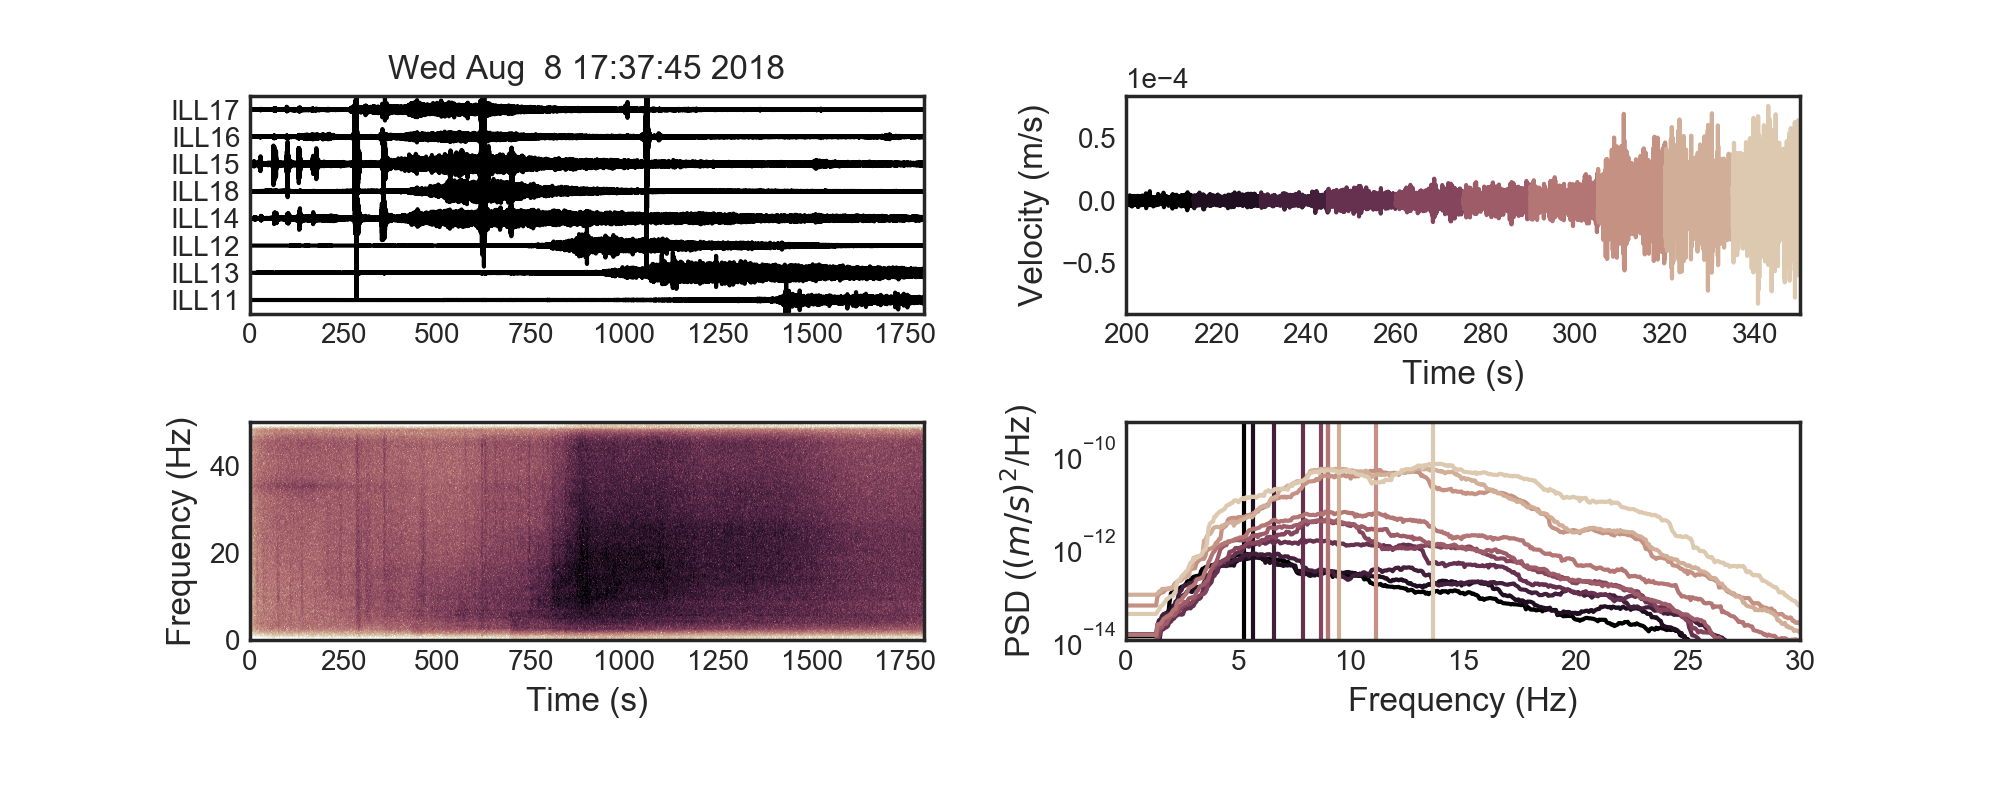

In [11]:
st1 = st_ev.copy()
st1.trim(t_ref - 15*60, t_ref + 45*60)
st1.normalize()

fig = plt.figure(figsize=(10,4))
cmap = sns.cubehelix_palette(as_cmap=True, start=0.3, light=1.8, dark=-0.05)

# Plot seismograms of all stations
ax1 = plt.subplot(221)
ax1.plot(st1[6].times(), st1[6].data*1, color='k')
ax1.plot(st1[5].times(), st1[5].data*12 - 2, color='k')
ax1.plot(st1[4].times(), st1[4].data*8 - 4, color='k')
ax1.plot(st1[7].times(), st1[7].data*1 - 6, color='k')
ax1.plot(st1[3].times(), st1[3].data*6 - 8, color='k')
ax1.plot(st1[1].times(), st1[1].data*1.5 - 10, color='k')
ax1.plot(st1[2].times(), st1[2].data*1.5 - 12, color='k')
ax1.plot(st1[0].times(), st1[0].data*1.5 - 14, color='k')

ax1.set_xlim(0, 1800)
ax1.set_ylim(-15, 1)
ax1.set_title(st1[0].stats.starttime.ctime())
labels = ['ILL17', 'ILL16', 'ILL15', 'ILL18', 'ILL14', 'ILL12', 'ILL13', 'ILL11']
plt.yticks(np.linspace(0,-14,8), labels)

# Plot spectrogram of station ILL12
ax2=plt.subplot(223)
ax2.specgram(st1.select(station='ILL12')[0].data, Fs=100, NFFT=512, pad_to=2048, noverlap=400, scale='dB', cmap=cmap)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=12)
ax2.set_xlim(0, 1800)


'''
Plot Zoom in increasing peak frequencies
'''
t0 = 200
t1 = 350
fs = tr2.stats.sampling_rate
tr2.filter('bandpass', freqmin=3, freqmax=25)

t_start = tr2.stats.starttime
tr2.trim(t_start + float(t0), t_start + float(t1))
win = int(len(tr2.data)/10)
colors = sns.cubehelix_palette(10, start=0.3,light=0.8, dark=0, reverse=True)

ax3 = plt.subplot(224)
# Plot spectra with colorcode
i = 0 
j = 0
while i < len(tr2.data)-win:
    dat = tr2.data[i:i+win]
    f, Pxx = scipy.signal.periodogram(dat, fs)
    pxx_sm = obspy.signal.util.smooth(Pxx, 20)
    ax3.semilogy(f, pxx_sm, color = colors[j])
    ax3.axvline(f[np.argmax(pxx_sm)], color = colors[j])
    i += win
    j += 1
ax3.set_xlim(0, 30)
ax3.set_ylim(1e-14, 5e-10)
ax3.set_xlabel('Frequency (Hz)', fontsize=(12))
ax3.set_ylabel('PSD ($(m/s)^2$/Hz)', fontsize = 12)


# Plot waveform with colorcode
ax4 = plt.subplot(222)
x = np.linspace(int(t0), int(t1), len(tr2.data))
i = 0 
j = 0
while i < len(tr2.data)-win:
    dat = tr2.data[i:i+win]
    xdat = x[i:i+win]
    ax4.plot(xdat, dat, color = colors[j])
    i += win
    j += 1
ax4.set_xlim(int(t0), int(t1))
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_ylabel('Velocity (m/s)', fontsize=12)
ax4.ticklabel_format( axis='y', style='sci', scilimits=(2,2))

fig.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.2)

plt.show()

## Plot dominant frequencies of all events alligned by geophone data recorded at CD1

In [13]:
station17 = 'ILL02'
station18 = 'ILL12'
st_all = obspy.core.stream.Stream() 
for i in list(dates_flows.values()):
    ev_date = UTCDateTime(i)
    print(ev_date)
    event = infos.loc[infos['date'] == i]
    #read event times from file, t_ref being station of interest
    t_CD01 = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeCD1'])) # read data
    if ev_date.year == 2017:
        st = obspy.read('./material/*%3d*' %(t_CD01.julday))
        inv = obspy.read_inventory('./material/ILL1-8_inventory.xml') 
    elif ev_date.year == 2018:
        st = obspy.read('./material/XP.%s.*%3d*' %(station18, t_CD01.julday))
        inv = obspy.read_inventory('./material/ILL11-18_inventory.xml')
    st.trim(t_CD01 - 7200, t_CD01 + 7200)
    st.merge(method=1, fill_value='interpolate')

    st = rere(st, inv)
    st.filter('bandpass', freqmin=1, freqmax=30)
    st_all.append(st[0])

2017-05-29T00:00:00.000000Z
2017-06-03T00:00:00.000000Z
2017-06-14T00:00:00.000000Z
2018-06-11T00:00:00.000000Z
2018-06-12T00:00:00.000000Z
2018-07-25T00:00:00.000000Z
2018-08-08T00:00:00.000000Z


<IPython.core.display.Javascript object>


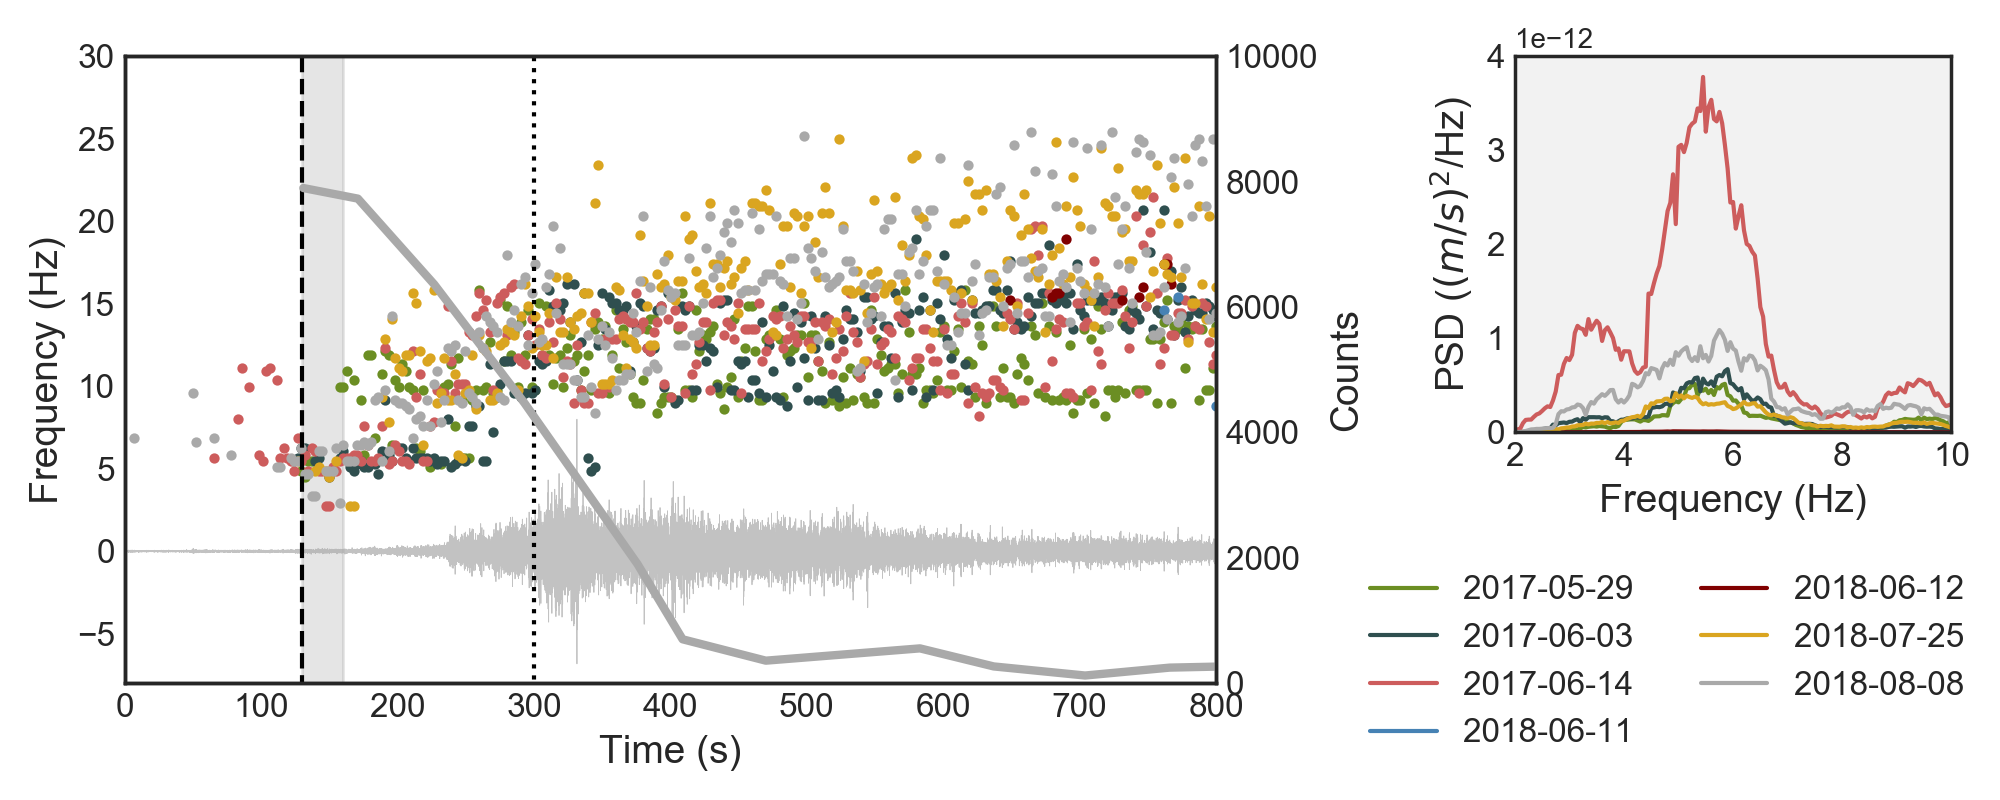

In [14]:
def vgl_domfreq(st2, sm):
    '''
    Compare dominant frequencies of each event. Data shifted according to onset of geophone recordings on CD!
    :param st2: Stream of all recorded events
    :type st2: obspy.core.stream.Stream
    :param sm: smoothing factor
    :type sm: int
    '''
    colors = ['olivedrab', 'darkslategrey', 'indianred', 'steelblue', 'maroon', 'goldenrod', 'darkgray']

    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2,width_ratios=[15, 6])

    ax1 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax2 = ax1.twinx()
    for idx, tr in enumerate(st2):
        trtime = tr.stats.starttime
        
        #Read geophone data
        cd_data = pd.read_csv('/Users/michiwen/Illgraben/data/debris_flows/%02d%02d%02d_Staumauer_Ereignisdaten.dat' \
                              %(trtime.year-2000, trtime.month, trtime.day), \
                              names = ["bla1", "bla2", "bla3", "date", "counts"])
        cddate = pd.to_datetime(cd_data["date"]) - datetime.timedelta(hours=1)
        cdcounts = cd_data["counts"]
        cd_utc = []
        for i in cddate:
            cd_utc.append(UTCDateTime(pd.to_datetime(i)))

        cd_secs = []
        for i in cd_utc:
            cd_secs.append(UTCDateTime(i) - tr.stats.starttime)
        
        cd_secs = np.asarray(cd_secs)
        if tr.stats.starttime.date == datetime.date(2017, 5, 29):
            shift = 0
            tr.data = np.roll(tr.data, shift*100)
            tr_norm = tr.copy()
            tr_norm.normalize()
            x_norm = np.linspace(0 ,len(tr_norm.data)/100 , len(tr_norm.data))
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2017, 6, 3):
            shift = 31
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2017, 6, 14):
            shift = 31
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 6, 11):
            shift = -68
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 6, 12):
            shift = -159
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 7, 25):
            shift = -342
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 8, 8):
            shift = -226 
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
            tr_norm = tr.copy()
            tr_norm.normalize()
            x_norm = np.linspace(0 ,len(tr_norm.data)/100 , len(tr_norm.data))
            ax1.plot(x_norm-7100, 8*tr_norm.data, color=colors[idx], alpha=0.7, linewidth=0.3)

        f_spec, t, Sxx = scipy.signal.spectrogram(tr.data, fs, nperseg=512, noverlap = 256)

        dom_fs = []
        en_values = []
        t_thres = []
        for i in range(Sxx.shape[1]):
            sxx_sm = obspy.signal.util.smooth(Sxx[:,i], 0) 
            dom_e = np.argmax(sxx_sm)
            if np.max(sxx_sm) > 1e-12:
                en_values.append(np.max(sxx_sm)) 
                dom_fs.append(f_spec[dom_e])
            else:
                en_values.append(0)
                dom_fs.append(100)
        dom_sm = obspy.signal.util.smooth(np.asarray(dom_fs), sm)


        domt_date = []
        for i in range(len(t)):
            domt_date.append(tr.stats.starttime.datetime + datetime.timedelta(seconds=t[i]))
        ax1.plot(np.asarray(t) - 7100, dom_sm, 'o', label=tr.stats.starttime.date, color=colors[idx], \
                 markeredgewidth=0.7, markersize=3, alpha=1)

        
        # Plot geophone counts
        if idx == 6:
            ax2.plot(np.asarray(cd_secs) - 7100,cdcounts, linewidth=3, color = colors[idx], label=tr.stats.starttime.date)
         
        # Compute spectra
        tr1 = tr.copy()
        tr1.filter('bandpass', freqmin=3, freqmax=10)
        dat = tr1[7230*100:7250*100]
        f_bla, Pxx_bla = scipy.signal.periodogram(dat, 100)
        Pxx_sm = obspy.signal.util.smooth(Pxx_bla, 10)
        ax3.plot(f_bla, Pxx_sm, color = colors[idx], label=tr.stats.starttime.date)
        ax3.set_xlim(2, 10)
        ax3.tick_params(axis='both', labelsize='large')
        ax3.set_xlabel('Frequency (Hz)', fontsize = 14)
        ax3.set_ylabel('PSD ($(m/s)^2$/Hz)', fontsize = 14)
        ax3.set_ylim(0,4e-12)

        

    ax1.tick_params(axis='both', labelsize='large')
    ax1.set_ylabel('Frequency (Hz)', fontsize = 14)
    ax1.set_xlabel('Time (s)', fontsize = 14)
    ax1.set_xlim(0, 800)
    ax1.set_ylim(-8, 30) 
    ax2.set_ylim(0,10000)
    ax2.set_ylabel('Counts', fontsize = 14)
    ax2.tick_params(axis='both', labelsize='large')
    plt.tight_layout()
    box = ax1.get_position()

    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0 + box.height * 0.4,
                 box.width, box.height * 0.6])

    # Put a legend below current axis
    ax3.legend(loc='upper left', bbox_to_anchor=(-0.4, -0.3),
          fancybox=True, shadow=True, ncol=2, fontsize=12)
    ax1.fill_between(np.linspace(130, 160, 10), -8, 30, color='grey', alpha=0.2)
    ax3.fill_between(np.linspace(2, 10, 10), 0, 4e-12, color='grey', alpha=0.1)
    ax1.axvline(x=130, ymin=-8, ymax=30, color='k', linestyle='--')
    ax1.axvline(x=300, ymin=-8, ymax=30, color='k', linestyle=':')
    plt.show()



st1 = st_all.copy()
fs = 100
smoothing = 0
vgl_domfreq(st1, smoothing)